# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/vit_224_1024.csv'
static = '../Tabular_data/dengue_tabular.csv'
embeddings_dir = 'Embeddings/'

labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/ResNet50V2_224_1024.csv')['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=3
autoregressive = True
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='GRU'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe fo

list

## 2. Preprocessing

### Train Test split

In [4]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201547  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201548  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201549  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201550  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   

                     6         7      8         9  ...  \
41001 201546 -0.093779  0.015505  0.614 -0.552001  ...   
      201547 -0.093779  0.015505  0.614 -0.552001  ...   
      201548 -0.093779  0.015505  0.614 -0.552001  ...   
      201549 -0.093779  0.015505  0.614 -0.552001  ...   
      201550 -0.093779  0.015505  0.614 -0.552001  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201546                   -0.543915                         1.0   
      201547                   -0.543915                         1.0   
      201548                   -0.543915                         1.0   
      201549                   -0.543915                         1.0   
      201550                   -0.543915                         1.0   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201546                   -0.856306                   -0.851179   
      201547                   -0.856306                   -0.851179   
      201548                   -0.856306                   -0.851179   
      201549                   -0.856306                   -0.851179   
      201550                   -0.856306                   -0.851179   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201546                   -0.990934                        -1.0   
      201547                   -0.990934                        -1.0   
      201548                   -0.990934                        -1.0   
      201549                   -0.990934                        -1.0   
      201550                   -0.990934                        -1.0   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201546                -0.990366             -0.974456        -1.0   
      201547                -0.990366             -0.974456        -1.0   
      201548                -0.990366             -0.974456        -1.0   
      201549                -0.990366             -0.974456        -1.0   
      201550                -0.990366             -0.974456        -1.0   

                Labels  
41001 201546 -0.861740  
      201547 -0.854589  
      201548 -0.856973  
      201549 -0.856973  
      201550 -0.823600  

[5 rows x 795 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4         5  \
5360 201546  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
     201547 -0.320510  0.119825  0.137270  0.216795 -0.476022  0.158546   
     201548  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
     201549 -0.444779  0.071139  0.012459 -0.366217 -0.225480 -0.081610   
     201550  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   

                    6         7         8         9  ...  \
5360 201546 -0.093779  0.015505  0.614000 -0.552001  ...   
     201547 -0.570430 -0.044212  0.344147 -0.219893  ...   
     201548 -0.093779  0.015505  0.614000 -0.552001  ...   
     201549 -0.170546 -0.254429  0.199990 -0.249487  ...   
     201550 -0.093779  0.015505  0.614000 -0.552001  ...   

             Buildingstratification1(%)  Buildingstratification2(%)  \
5360 201546                   -1.234579                    0.609378   
     201547                   -1.234579                    0.609378   
     201548                   -1.234579                    0.609378   
     201549                   -1.234579                    0.609378   
     201550                   -1.234579                    0.609378   

             Buildingstratification3(%)  Buildingstratification4(%)  \
5360 201546                    2.479911                   -0.856684   
     201547                    2.479911                   -0.856684   
     201548                    2.479911                   -0.856684   
     201549                    2.479911                   -0.856684   
     201550                    2.479911                   -0.856684   

             Buildingstratification5(%)  Buildingstratification6(%)  \
5360 201546                   -1.276395                   -1.018312   
     201547                   -1.276395                   -1.018312   
     201548                   -1.276395                   -1.018312   
     201549                   -1.276395                   -1.018312   
     201550                   -1.276395                   -1.018312   

             NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
5360 201546                -0.489792               3.68679   -1.078709   
     201547                -0.489792               3.68679   -1.078709   
     201548                -0.489792               3.68679   -1.078709   
     201549                -0.489792               3.68679   -1.078709   
     201550                -0.489792               3.68679   -1.078709   

               Labels  
5360 201546 -0.990465  
     201547 -0.969011  
     201548 -0.995232  
     201549 -0.997616  
     201550 -0.971395  

[5 rows x 795 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(160, 3180)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [10]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 2385)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (320, 2385)
The shape of the labels is (320, 1)


In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 2385)
The test shape is (320, 2385)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 795)
The test shape is (320, 3, 795)


# 2. Model

In [12]:
x_ar = train_X[:, :, -1:]
x_ar_test = test_X[:, :, -1:]

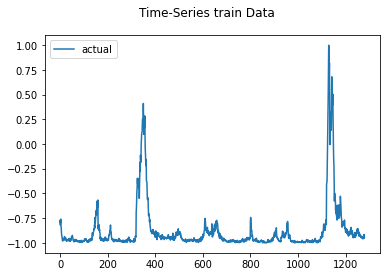

2023-03-04 15:56:03.229319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-04 15:56:03.229398: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-04 15:56:03.229463: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-04 15:56:03.230741: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 15:56:11.598744: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_input (InputLayer)          [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_2_input (InputLayer)        [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1)            7802971     gru_input[0][0]                  
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            5420971     gru_2_input[0][0]                
______________________________________________________________________________________________

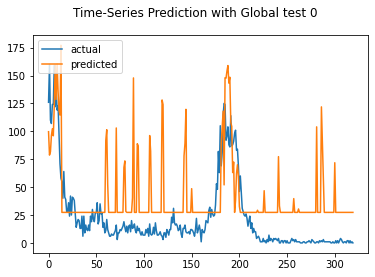

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_4_input (InputLayer)        [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_6_input (InputLayer)        [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            7802971     gru_4_input[0][0]                
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1)            5420971     gru_6_input[0][0]                
________

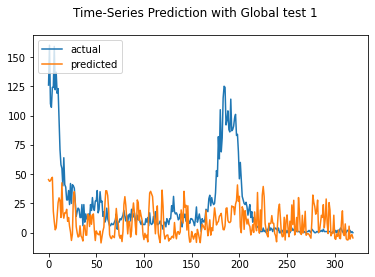

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_8_input (InputLayer)        [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_10_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1)            7802971     gru_8_input[0][0]                
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1)            5420971     gru_10_input[0][0]               
____________________________________________________________________________________________

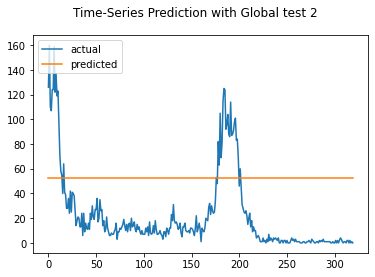

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_12_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_14_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1)            7802971     gru_12_input[0][0]               
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 1)            5420971     gru_14_input[0][0]               
________

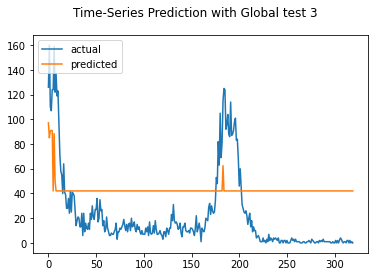

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_16_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_18_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 1)            7802971     gru_16_input[0][0]               
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 1)            5420971     gru_18_input[0][0]               
________

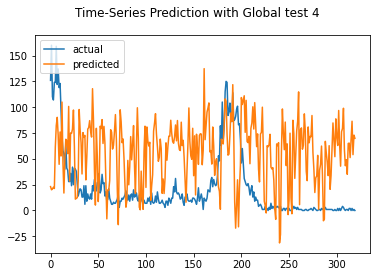

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_20_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_22_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 1)            7802971     gru_20_input[0][0]               
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 1)            5420971     gru_22_input[0][0]               
____________________________________________________________________________________________

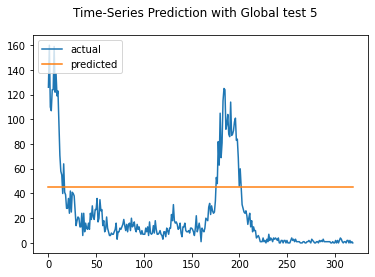

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_24_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_26_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 1)            7802971     gru_24_input[0][0]               
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 1)            5420971     gru_26_input[0][0]               
____________________________________________________________________________________________

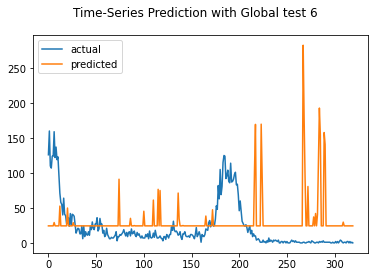

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_28_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_30_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 1)            7802971     gru_28_input[0][0]               
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 1)            5420971     gru_30_input[0][0]               
____________________________________________________________________________________________

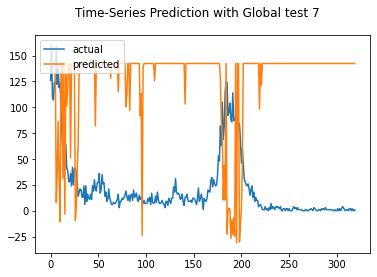

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_32_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_34_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 1)            7802971     gru_32_input[0][0]               
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 1)            5420971     gru_34_input[0][0]               
____________________________________________________________________________________________

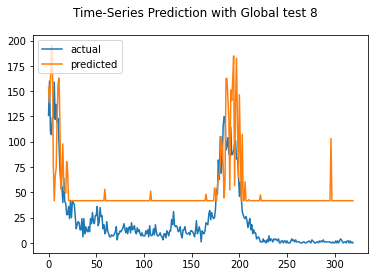

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_36_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_38_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_18 (Sequential)      (None, 1)            7802971     gru_36_input[0][0]               
__________________________________________________________________________________________________
sequential_19 (Sequential)      (None, 1)            5420971     gru_38_input[0][0]               
________

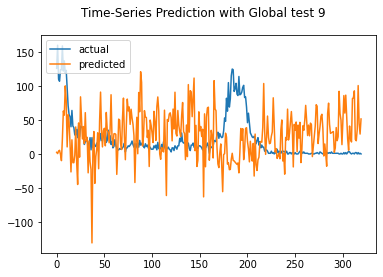

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_40_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_42_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, 1)            7802971     gru_40_input[0][0]               
__________________________________________________________________________________________________
sequential_21 (Sequential)      (None, 1)            5420971     gru_42_input[0][0]               
_______

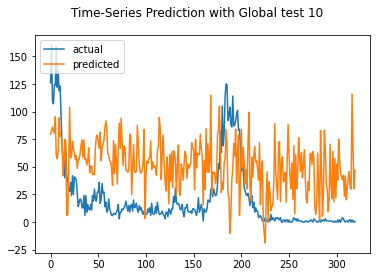

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_44_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_46_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_22 (Sequential)      (None, 1)            7802971     gru_44_input[0][0]               
__________________________________________________________________________________________________
sequential_23 (Sequential)      (None, 1)            5420971     gru_46_input[0][0]               
_______

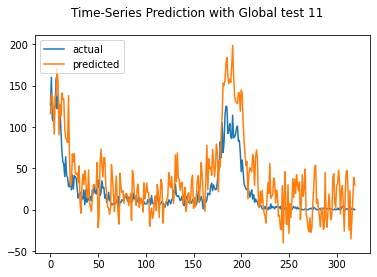

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_48_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_50_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, 1)            7802971     gru_48_input[0][0]               
__________________________________________________________________________________________________
sequential_25 (Sequential)      (None, 1)            5420971     gru_50_input[0][0]               
___________________________________________________________________________________________

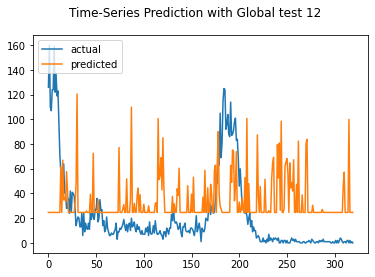

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_52_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_54_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_26 (Sequential)      (None, 1)            7802971     gru_52_input[0][0]               
__________________________________________________________________________________________________
sequential_27 (Sequential)      (None, 1)            5420971     gru_54_input[0][0]               
_______

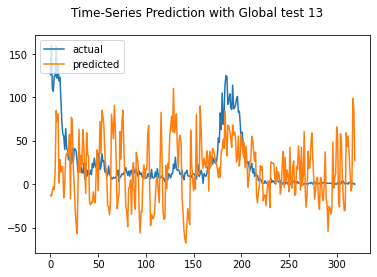

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_56_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_58_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_28 (Sequential)      (None, 1)            7802971     gru_56_input[0][0]               
__________________________________________________________________________________________________
sequential_29 (Sequential)      (None, 1)            5420971     gru_58_input[0][0]               
_______

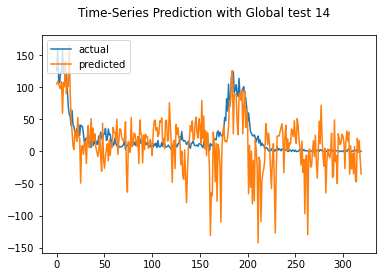

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_60_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_62_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_30 (Sequential)      (None, 1)            7802971     gru_60_input[0][0]               
__________________________________________________________________________________________________
sequential_31 (Sequential)      (None, 1)            5420971     gru_62_input[0][0]               
_______

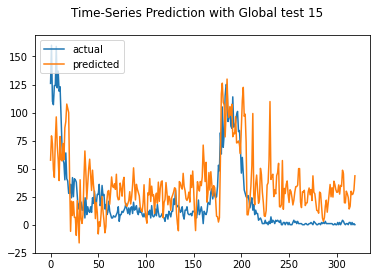

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_64_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_66_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_32 (Sequential)      (None, 1)            7802971     gru_64_input[0][0]               
__________________________________________________________________________________________________
sequential_33 (Sequential)      (None, 1)            5420971     gru_66_input[0][0]               
_______

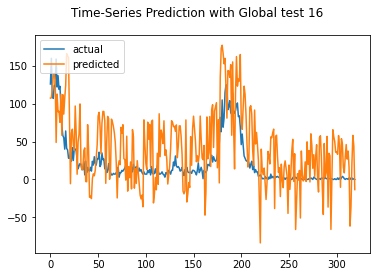

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_68_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_70_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_34 (Sequential)      (None, 1)            7802971     gru_68_input[0][0]               
__________________________________________________________________________________________________
sequential_35 (Sequential)      (None, 1)            5420971     gru_70_input[0][0]               
___________________________________________________________________________________________

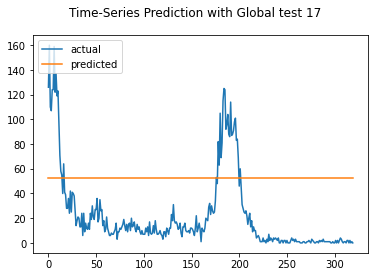

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_72_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_74_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_36 (Sequential)      (None, 1)            7802971     gru_72_input[0][0]               
__________________________________________________________________________________________________
sequential_37 (Sequential)      (None, 1)            5420971     gru_74_input[0][0]               
_______

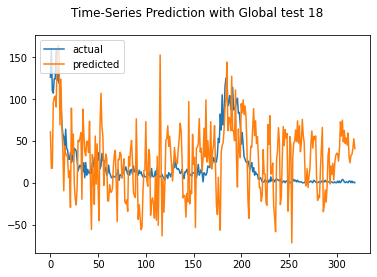

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_76_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_78_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_38 (Sequential)      (None, 1)            7802971     gru_76_input[0][0]               
__________________________________________________________________________________________________
sequential_39 (Sequential)      (None, 1)            5420971     gru_78_input[0][0]               
_______

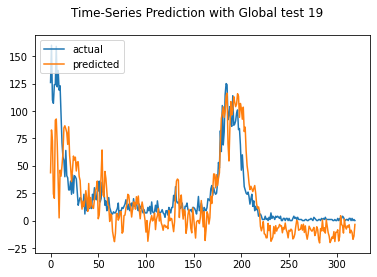

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_80_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_82_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_40 (Sequential)      (None, 1)            7802971     gru_80_input[0][0]               
__________________________________________________________________________________________________
sequential_41 (Sequential)      (None, 1)            5420971     gru_82_input[0][0]               
___________________________________________________________________________________________

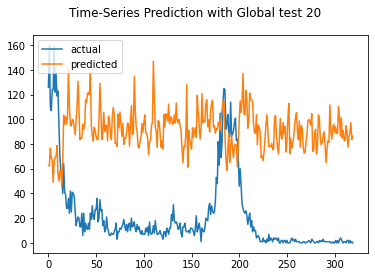

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_84_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_86_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_42 (Sequential)      (None, 1)            7802971     gru_84_input[0][0]               
__________________________________________________________________________________________________
sequential_43 (Sequential)      (None, 1)            5420971     gru_86_input[0][0]               
___________________________________________________________________________________________

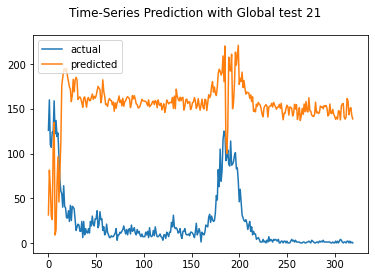

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_88_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_90_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_44 (Sequential)      (None, 1)            7802971     gru_88_input[0][0]               
__________________________________________________________________________________________________
sequential_45 (Sequential)      (None, 1)            5420971     gru_90_input[0][0]               
___________________________________________________________________________________________

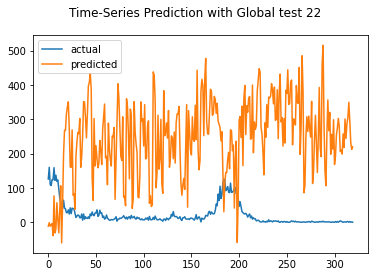

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_92_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_94_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_46 (Sequential)      (None, 1)            7802971     gru_92_input[0][0]               
__________________________________________________________________________________________________
sequential_47 (Sequential)      (None, 1)            5420971     gru_94_input[0][0]               
_______

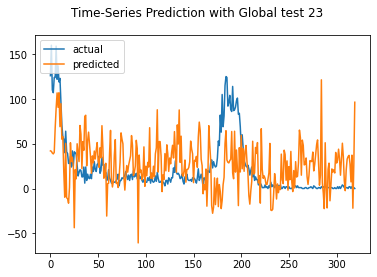

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_96_input (InputLayer)       [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_98_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_48 (Sequential)      (None, 1)            7802971     gru_96_input[0][0]               
__________________________________________________________________________________________________
sequential_49 (Sequential)      (None, 1)            5420971     gru_98_input[0][0]               
_______

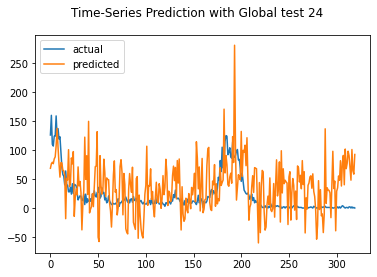

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_100_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_102_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_50 (Sequential)      (None, 1)            7802971     gru_100_input[0][0]              
__________________________________________________________________________________________________
sequential_51 (Sequential)      (None, 1)            5420971     gru_102_input[0][0]              
_______

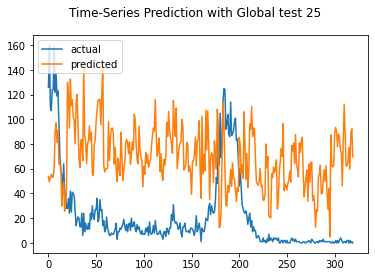

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_104_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_106_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_52 (Sequential)      (None, 1)            7802971     gru_104_input[0][0]              
__________________________________________________________________________________________________
sequential_53 (Sequential)      (None, 1)            5420971     gru_106_input[0][0]              
_______

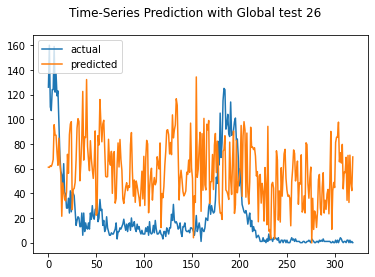

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_108_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_110_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_54 (Sequential)      (None, 1)            7802971     gru_108_input[0][0]              
__________________________________________________________________________________________________
sequential_55 (Sequential)      (None, 1)            5420971     gru_110_input[0][0]              
___________________________________________________________________________________________

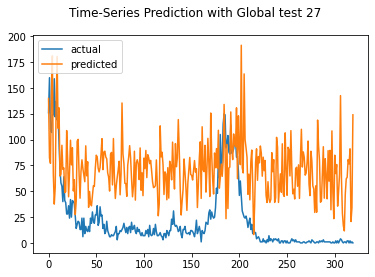

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_112_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_114_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_56 (Sequential)      (None, 1)            7802971     gru_112_input[0][0]              
__________________________________________________________________________________________________
sequential_57 (Sequential)      (None, 1)            5420971     gru_114_input[0][0]              
___________________________________________________________________________________________

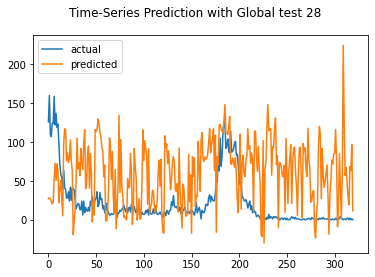

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_116_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_118_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_58 (Sequential)      (None, 1)            7802971     gru_116_input[0][0]              
__________________________________________________________________________________________________
sequential_59 (Sequential)      (None, 1)            5420971     gru_118_input[0][0]              
_______

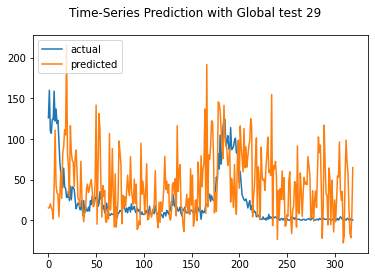

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_120_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_122_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_60 (Sequential)      (None, 1)            7802971     gru_120_input[0][0]              
__________________________________________________________________________________________________
sequential_61 (Sequential)      (None, 1)            5420971     gru_122_input[0][0]              
___________________________________________________________________________________________

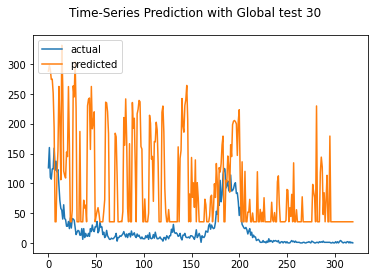

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_124_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_126_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_62 (Sequential)      (None, 1)            7802971     gru_124_input[0][0]              
__________________________________________________________________________________________________
sequential_63 (Sequential)      (None, 1)            5420971     gru_126_input[0][0]              
_______

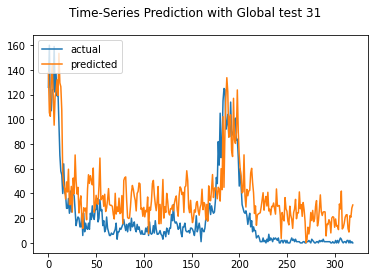

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_128_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_130_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_64 (Sequential)      (None, 1)            7802971     gru_128_input[0][0]              
__________________________________________________________________________________________________
sequential_65 (Sequential)      (None, 1)            5420971     gru_130_input[0][0]              
_______

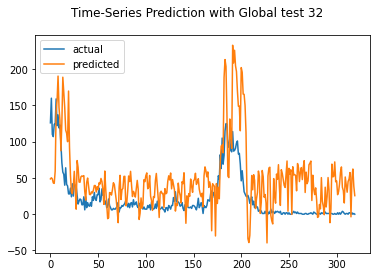

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_132_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_134_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_66 (Sequential)      (None, 1)            7802971     gru_132_input[0][0]              
__________________________________________________________________________________________________
sequential_67 (Sequential)      (None, 1)            5420971     gru_134_input[0][0]              
_______

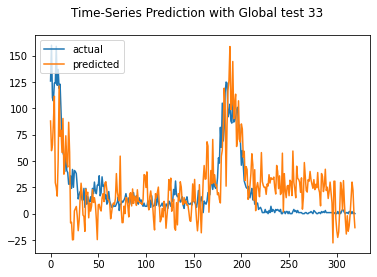

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_136_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_138_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_68 (Sequential)      (None, 1)            7802971     gru_136_input[0][0]              
__________________________________________________________________________________________________
sequential_69 (Sequential)      (None, 1)            5420971     gru_138_input[0][0]              
_______

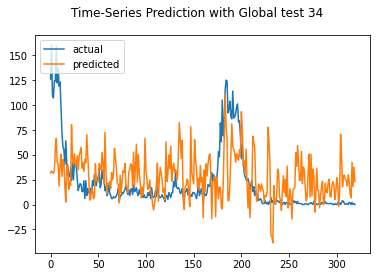

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_140_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_142_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_70 (Sequential)      (None, 1)            7802971     gru_140_input[0][0]              
__________________________________________________________________________________________________
sequential_71 (Sequential)      (None, 1)            5420971     gru_142_input[0][0]              
___________________________________________________________________________________________

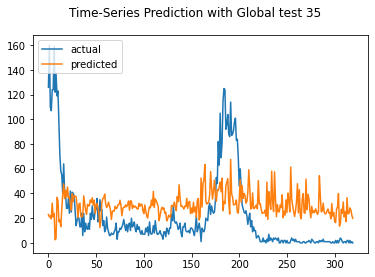

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_144_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_146_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_72 (Sequential)      (None, 1)            7802971     gru_144_input[0][0]              
__________________________________________________________________________________________________
sequential_73 (Sequential)      (None, 1)            5420971     gru_146_input[0][0]              
_______

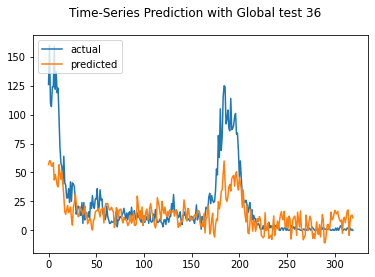

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_148_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_150_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_74 (Sequential)      (None, 1)            7802971     gru_148_input[0][0]              
__________________________________________________________________________________________________
sequential_75 (Sequential)      (None, 1)            5420971     gru_150_input[0][0]              
_______

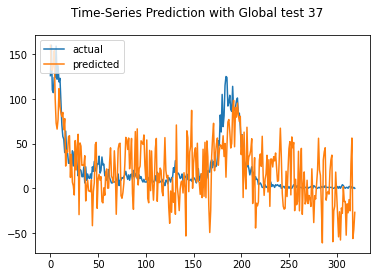

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_152_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_154_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_76 (Sequential)      (None, 1)            7802971     gru_152_input[0][0]              
__________________________________________________________________________________________________
sequential_77 (Sequential)      (None, 1)            5420971     gru_154_input[0][0]              
_______

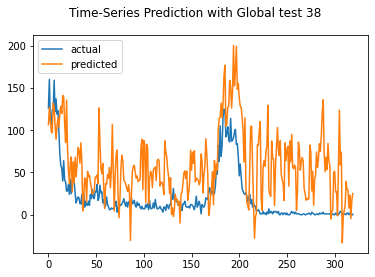

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_156_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_158_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_78 (Sequential)      (None, 1)            7802971     gru_156_input[0][0]              
__________________________________________________________________________________________________
sequential_79 (Sequential)      (None, 1)            5420971     gru_158_input[0][0]              
_______

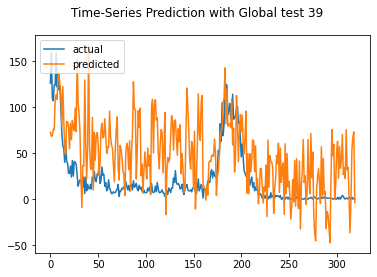

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_160_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_162_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_80 (Sequential)      (None, 1)            7802971     gru_160_input[0][0]              
__________________________________________________________________________________________________
sequential_81 (Sequential)      (None, 1)            5420971     gru_162_input[0][0]              
___________________________________________________________________________________________

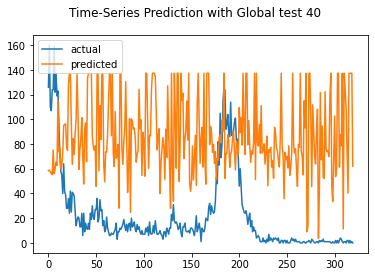

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_164_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_166_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_82 (Sequential)      (None, 1)            7802971     gru_164_input[0][0]              
__________________________________________________________________________________________________
sequential_83 (Sequential)      (None, 1)            5420971     gru_166_input[0][0]              
___________________________________________________________________________________________

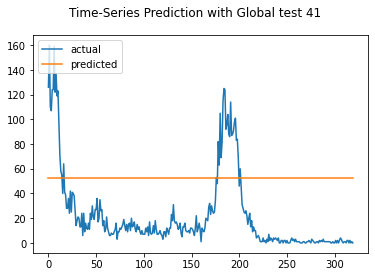

Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_168_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_170_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_84 (Sequential)      (None, 1)            7802971     gru_168_input[0][0]              
__________________________________________________________________________________________________
sequential_85 (Sequential)      (None, 1)            5420971     gru_170_input[0][0]              
___________________________________________________________________________________________

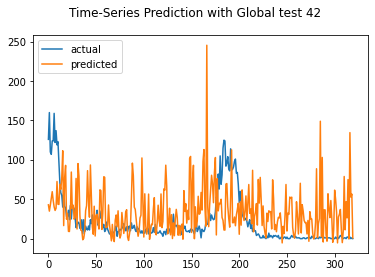

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_172_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_174_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_86 (Sequential)      (None, 1)            7802971     gru_172_input[0][0]              
__________________________________________________________________________________________________
sequential_87 (Sequential)      (None, 1)            5420971     gru_174_input[0][0]              
_______

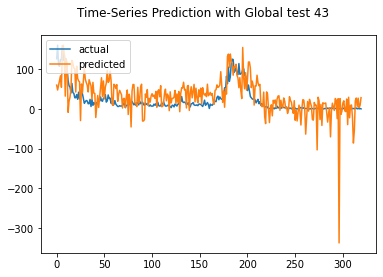

Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_176_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_178_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_88 (Sequential)      (None, 1)            7802971     gru_176_input[0][0]              
__________________________________________________________________________________________________
sequential_89 (Sequential)      (None, 1)            5420971     gru_178_input[0][0]              
___________________________________________________________________________________________

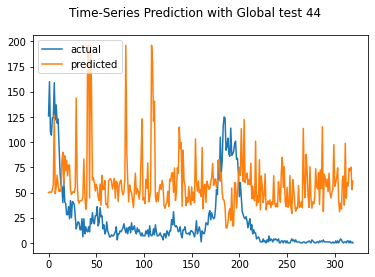

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_180_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_182_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_90 (Sequential)      (None, 1)            7802971     gru_180_input[0][0]              
__________________________________________________________________________________________________
sequential_91 (Sequential)      (None, 1)            5420971     gru_182_input[0][0]              
_______

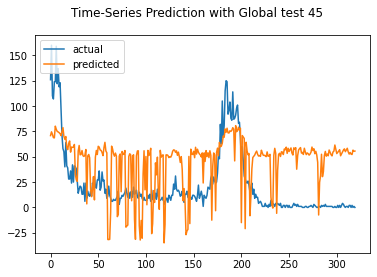

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_184_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_186_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_92 (Sequential)      (None, 1)            7802971     gru_184_input[0][0]              
__________________________________________________________________________________________________
sequential_93 (Sequential)      (None, 1)            5420971     gru_186_input[0][0]              
_______

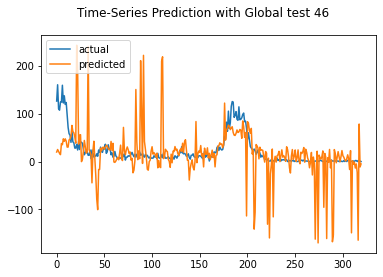

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_188_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_190_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_94 (Sequential)      (None, 1)            7802971     gru_188_input[0][0]              
__________________________________________________________________________________________________
sequential_95 (Sequential)      (None, 1)            5420971     gru_190_input[0][0]              
_______

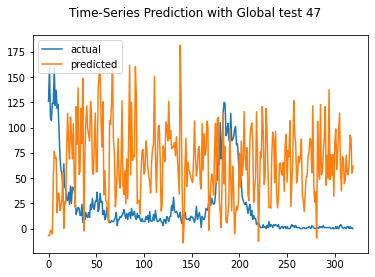

Model: "model_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_192_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_194_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_96 (Sequential)      (None, 1)            7802971     gru_192_input[0][0]              
__________________________________________________________________________________________________
sequential_97 (Sequential)      (None, 1)            5420971     gru_194_input[0][0]              
___________________________________________________________________________________________

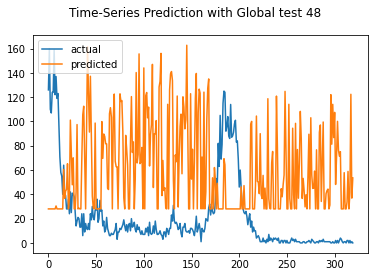

Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_196_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_198_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_98 (Sequential)      (None, 1)            7802971     gru_196_input[0][0]              
__________________________________________________________________________________________________
sequential_99 (Sequential)      (None, 1)            5420971     gru_198_input[0][0]              
___________________________________________________________________________________________

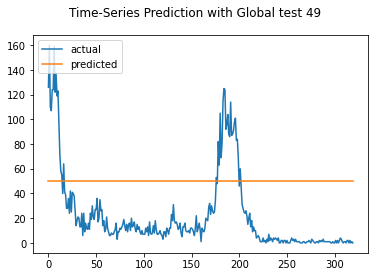

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Model: "model_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_200_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_202_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_100 (Sequential)     (None, 1)            7802971     gru_200_input[0][0]              
__________________________________________________________________________________________________
sequential_101 (Sequential)     (None, 1)            5420971     gru_202_input[0][0]              
_______

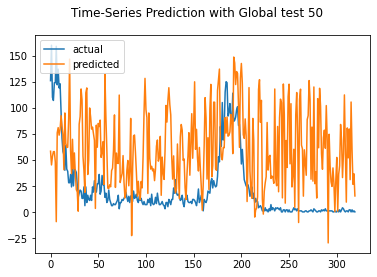

Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_204_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_206_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_102 (Sequential)     (None, 1)            7802971     gru_204_input[0][0]              
__________________________________________________________________________________________________
sequential_103 (Sequential)     (None, 1)            5420971     gru_206_input[0][0]              
___________________________________________________________________________________________

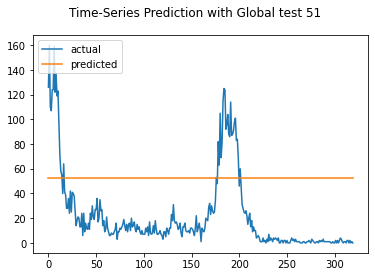

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_208_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_210_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_104 (Sequential)     (None, 1)            7802971     gru_208_input[0][0]              
__________________________________________________________________________________________________
sequential_105 (Sequential)     (None, 1)            5420971     gru_210_input[0][0]              
_______

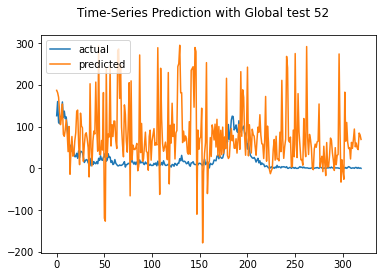

Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_212_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_214_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_106 (Sequential)     (None, 1)            7802971     gru_212_input[0][0]              
__________________________________________________________________________________________________
sequential_107 (Sequential)     (None, 1)            5420971     gru_214_input[0][0]              
___________________________________________________________________________________________

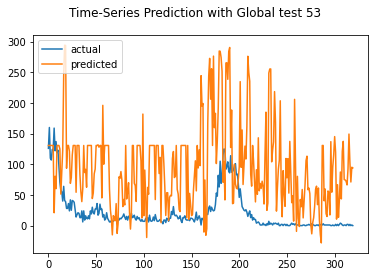

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Model: "model_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_216_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_218_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_108 (Sequential)     (None, 1)            7802971     gru_216_input[0][0]              
__________________________________________________________________________________________________
sequential_109 (Sequential)     (None, 1)            5420971     gru_218_input[0][0]              
_______

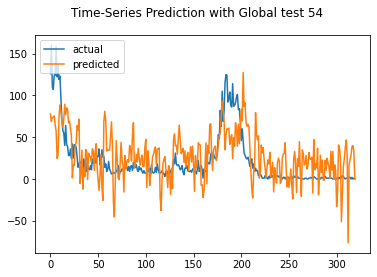

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_220_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_222_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_110 (Sequential)     (None, 1)            7802971     gru_220_input[0][0]              
__________________________________________________________________________________________________
sequential_111 (Sequential)     (None, 1)            5420971     gru_222_input[0][0]              
_______

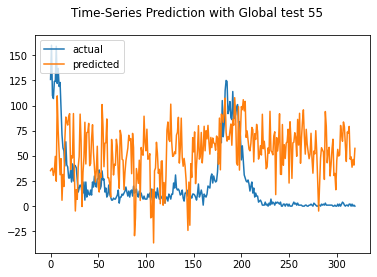

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Model: "model_56"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_224_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_226_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_112 (Sequential)     (None, 1)            7802971     gru_224_input[0][0]              
__________________________________________________________________________________________________
sequential_113 (Sequential)     (None, 1)            5420971     gru_226_input[0][0]              
_______

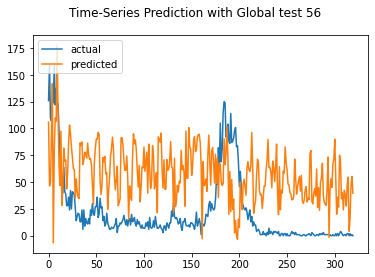

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_228_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_230_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_114 (Sequential)     (None, 1)            7802971     gru_228_input[0][0]              
__________________________________________________________________________________________________
sequential_115 (Sequential)     (None, 1)            5420971     gru_230_input[0][0]              
_______

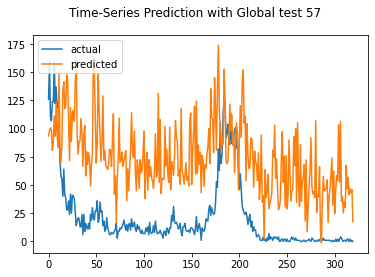

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Model: "model_58"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_232_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_234_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_116 (Sequential)     (None, 1)            7802971     gru_232_input[0][0]              
__________________________________________________________________________________________________
sequential_117 (Sequential)     (None, 1)            5420971     gru_234_input[0][0]              
_______

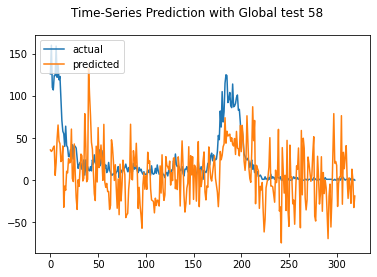

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Model: "model_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_236_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_238_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_118 (Sequential)     (None, 1)            7802971     gru_236_input[0][0]              
__________________________________________________________________________________________________
sequential_119 (Sequential)     (None, 1)            5420971     gru_238_input[0][0]              
_______

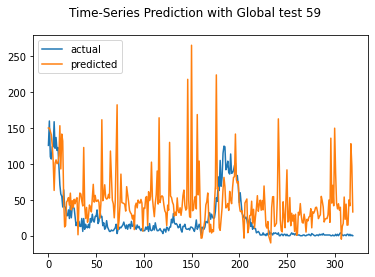

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Model: "model_60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_240_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_242_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_120 (Sequential)     (None, 1)            7802971     gru_240_input[0][0]              
__________________________________________________________________________________________________
sequential_121 (Sequential)     (None, 1)            5420971     gru_242_input[0][0]              
_______

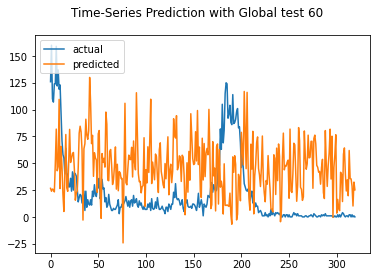

Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_244_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_246_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_122 (Sequential)     (None, 1)            7802971     gru_244_input[0][0]              
__________________________________________________________________________________________________
sequential_123 (Sequential)     (None, 1)            5420971     gru_246_input[0][0]              
___________________________________________________________________________________________

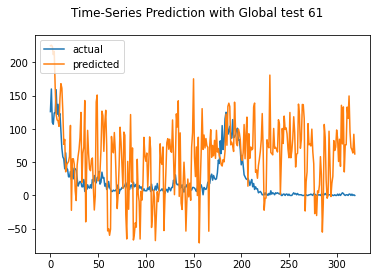

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Model: "model_62"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_248_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_250_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_124 (Sequential)     (None, 1)            7802971     gru_248_input[0][0]              
__________________________________________________________________________________________________
sequential_125 (Sequential)     (None, 1)            5420971     gru_250_input[0][0]              
_______

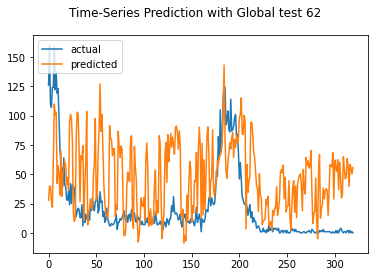

Model: "model_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_252_input (InputLayer)      [(None, 3, 795)]     0                                            
__________________________________________________________________________________________________
gru_254_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_126 (Sequential)     (None, 1)            7802971     gru_252_input[0][0]              
__________________________________________________________________________________________________
sequential_127 (Sequential)     (None, 1)            5420971     gru_254_input[0][0]              
___________________________________________________________________________________________

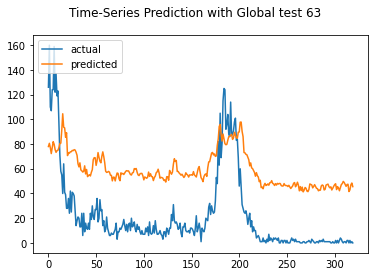

In [ ]:
# Use the Function:
sequence=train_X.shape[1]
features=train_X.shape[2]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global', fusion='joint', x_ar=x_ar, x_ar_test=x_ar_test)


In [ ]:
scalers['scaler_Labels'].inverse_transform(test_y).mean()

scalers['scaler_Labels'].inverse_transform(train_y).mean()